<a href="https://colab.research.google.com/github/shaoweiwang2010/SEII-AIOps_data/blob/main/Anomaly_detection_demo_(LR_%26_DT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Analyzing System Logs for Anomaly Detection</h1>

This demo shows an example of using system logs for anomaly detection. **Supervised learning** (e.g., logistic regression, decision tree, SVM) and **unsupervised learning** (clustering, PCA, invariants mining) methods have been used for the task of anomaly detection. In this example, we use supervised learning, specifically, a **logistic regression model** and a **decision tree model**, to indentify anomalies in system logs.

Log-based anomaly detection typically include four steps: **log collection**, **log parsing**, **feature extraction**, and **anomaly detection**. In this demo, we focus on the **feature extraction** and **anomaly detection** steps.

**Acknowledgement**:

Shilin He, Jieming Zhu, Pinjia He, Michael R. Lyu. Experience Report: System Log Analysis for Anomaly Detection, IEEE International Symposium on Software Reliability Engineering (ISSRE), 2016

## Import needed libraries and dependencies

Mount a google drive folder.

In [14]:
#from google.colab import drive
#drive.mount('/content/drive/')
#import sys
#sys.path.append('drive/My Drive/Colab Notebooks/AIOps-anomaly-detection-demo')

Import the needed libraries. We use the **logistic regression model** and the **decision tree model** provided by the **sklearn** library. We use the **numpy** and **pandas** libraries to deal with basic data structures (e.g., arrays and dataframes) used in our analysis.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from sklearn.utils import shuffle
from collections import OrderedDict
from collections import Counter


## Read the log data


### Read the data from a GitHub repo
We read the log data from a GitHub repository (https://github.com/shaoweiwang2010/SEII-AIOps_data). There are two files in the repo: the file *HDFS_100k.log_structured.csv* contains the structured (i.e., parsed) log data; the file *HDFS.anomaly_label.csv* contains the labels (normal/anomaly).
We read the csv files into **Pandas** dataframes.



In [16]:
struct_log_file = 'https://media.githubusercontent.com/media/shaoweiwang2010/SEII-AIOps_data/main/HDFS_100k.log_structured.csv'
struct_log = pd.read_csv(struct_log_file, engine='python', na_filter=False)

label_file = 'https://raw.githubusercontent.com/shaoweiwang2010/SEII-AIOps_data/main/HDFS.anomaly_label.csv'
label_data = pd.read_csv(label_file, engine='python', na_filter=False)

### Exploring the data
It is always a good practice to explore the data before doing any analysis.

In [17]:
print(type(struct_log))
print(struct_log.shape)
struct_log.head(5)

<class 'pandas.core.frame.DataFrame'>
(104815, 9)


,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate
0,1,81109,203518,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>
1,2,81109,203518,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,E22,BLOCK* NameSystem.allocateBlock:<*>
2,3,81109,203519,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>
3,4,81109,203519,145,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>
4,5,81109,203519,145,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_-1608999687919...,E11,PacketResponder <*> for block <*> terminating


In [18]:
print(type(label_data))
print(label_data.shape)
label_data.head(5)

<class 'pandas.core.frame.DataFrame'>
(575061, 2)


,BlockId,Label
0,blk_-1608999687919862906,Normal
1,blk_7503483334202473044,Normal
2,blk_-3544583377289625738,Anomaly
3,blk_-9073992586687739851,Normal
4,blk_7854771516489510256,Normal


In [19]:
struct_log.EventId.describe()
#struct_log.EventId.nunique()
struct_log.EventId.value_counts()

,count
EventId,
E5,23671
E26,23478
E11,23451
E9,23447
E22,7940
E2,2183
E3,407
E7,68
E6,31


## Preprocessing the data
This step extracts the event sequence for each block ID, and merges the event sequences with the labels (normal/anomaly) with the event sequences.

### Extracting the event sequence for each block ID
Using a regular expression to find the block IDs in each log line, then producing a list of event (i.e., a event sequence) for each block ID.

In [20]:
data_dict = OrderedDict()
for idx, row in struct_log.iterrows():
    blkId_list = re.findall(r'(blk_-?\d+)', row['Content'])
    blkId_set = set(blkId_list)
    for blk_Id in blkId_set:
        if not blk_Id in data_dict:
            data_dict[blk_Id] = []
        data_dict[blk_Id].append(row['EventId'])
data_df = pd.DataFrame(list(data_dict.items()), columns=['BlockId', 'EventSequence'])

print(type(data_df))
print(data_df.shape)
data_df.head(5)

<class 'pandas.core.frame.DataFrame'>
(7940, 2)


,BlockId,EventSequence
0,blk_-1608999687919862906,"[E5, E22, E5, E5, E11, E11, E9, E9, E11, E9, E..."
1,blk_7503483334202473044,"[E5, E5, E22, E5, E11, E9, E11, E9, E11, E9, E..."
2,blk_-3544583377289625738,"[E5, E22, E5, E5, E11, E9, E11, E9, E11, E9, E..."
3,blk_-9073992586687739851,"[E5, E22, E5, E5, E11, E9, E11, E9, E11, E9, E..."
4,blk_7854771516489510256,"[E5, E5, E22, E5, E11, E9, E11, E9, E11, E9, E..."


### Merging the label with the event sequence data
Merging the event sequence data with the label data by matching the block IDs.

In [29]:
label_data_indexed = label_data.set_index('BlockId')
label_dict = label_data_indexed['Label'].to_dict()
data_df['Label'] = data_df['BlockId'].apply(lambda x: 1 if label_dict[x] == 'Anomaly' else 0)

data_df.head(5)
data_df.Label.value_counts()


,count
Label,
0,7627
1,313


### Spliting the data into training and testing subsets
We split the data into 70% training data and 30% testing data.

A utility function that split the data into training and testing data by a specified ratio.

In [22]:
def _split_data(x_data, y_data, train_ratio=0.5):
    pos_idx = y_data > 0
    x_pos = x_data[pos_idx]
    y_pos = y_data[pos_idx]
    x_neg = x_data[~pos_idx]
    y_neg = y_data[~pos_idx]
    train_pos = int(train_ratio * x_pos.shape[0])
    train_neg = int(train_ratio * x_neg.shape[0])
    x_train = np.hstack([x_pos[0:train_pos], x_neg[0:train_neg]])
    y_train = np.hstack([y_pos[0:train_pos], y_neg[0:train_neg]])
    x_test = np.hstack([x_pos[train_pos:], x_neg[train_neg:]])
    y_test = np.hstack([y_pos[train_pos:], y_neg[train_neg:]])

    return (x_train, y_train), (x_test, y_test)

Shuffle and split the data into 70% training and 30% testing data.

In [97]:
# Shuffle the data
data_df = data_df.sample(frac=1,random_state=34).reset_index(drop=True)
data_df.head(5)

,BlockId,EventSequence,Label
0,blk_8827951563980824329,"[E5, E5, E22, E5, E9, E11, E9, E26, E26, E11, ...",1
1,blk_3546604582459271027,"[E22, E5, E5, E5, E26, E26, E26, E11, E9, E11,...",0
2,blk_-8287899980976827003,"[E22, E5, E5, E5, E26, E26, E26, E11, E9, E11,...",0
3,blk_4400744260157673280,"[E22, E5, E5, E5, E26, E26, E26, E11, E9, E11,...",0
4,blk_-6008397446568765070,"[E5, E22, E5, E5, E11, E9, E11, E9, E11, E9, E...",0


In [98]:
# Split train and test data
train_ratio = 0.7
(x_train, y_train), (x_test, y_test) = _split_data(data_df['EventSequence'].values,
    data_df['Label'].values, train_ratio)

Summarized the training and testing data.

In [99]:
num_train = x_train.shape[0]
num_test = x_test.shape[0]
num_total = num_train + num_test
num_train_pos = sum(y_train)
num_test_pos = sum(y_test)
num_pos = num_train_pos + num_test_pos

print('Total: {} instances, {} anomaly, {} normal' \
      .format(num_total, num_pos, num_total - num_pos))
print('Train: {} instances, {} anomaly, {} normal' \
      .format(num_train, num_train_pos, num_train - num_train_pos))
print('Test: {} instances, {} anomaly, {} normal\n' \
      .format(num_test, num_test_pos, num_test - num_test_pos))

#print(type(x_train))
print('====== x_train (first five lines) ======')
print(x_train[:5])

print('====== y_train (first five lines) ======')
print(y_train[:5])


#print(type(x_test))
print('====== x_test (first five lines) ======')
print(x_test[:5])

print('====== x_test (first five lines) ======')
print(y_test[:5])

Total: 7940 instances, 313 anomaly, 7627 normal
Train: 5557 instances, 219 anomaly, 5338 normal
Test: 2383 instances, 94 anomaly, 2289 normal

====== x_train (first five lines) ======
[list(['E5', 'E5', 'E22', 'E5', 'E9', 'E11', 'E9', 'E26', 'E26', 'E11', 'E9', 'E11', 'E26'])
 list(['E22', 'E5', 'E5', 'E5', 'E11', 'E9', 'E26', 'E26', 'E26', 'E11', 'E9', 'E11', 'E9'])
 list(['E22', 'E5', 'E5', 'E5', 'E26', 'E26', 'E11', 'E9', 'E11', 'E11', 'E9', 'E9', 'E26'])
 list(['E22', 'E5', 'E5', 'E5', 'E26', 'E11', 'E9', 'E11', 'E9', 'E26', 'E11', 'E9', 'E26'])
 list(['E22', 'E5', 'E5', 'E5', 'E26', 'E26', 'E26', 'E11', 'E9', 'E11', 'E9', 'E11', 'E9'])]
====== y_train (first five lines) ======
[1 1 1 1 1]
====== x_test (first five lines) ======
[list(['E22', 'E5', 'E5', 'E7'])
 list(['E22', 'E5', 'E5', 'E5', 'E26', 'E26', 'E26', 'E11', 'E9', 'E11', 'E9', 'E11', 'E9'])
 list(['E22', 'E5', 'E5', 'E7'])
 list(['E5', 'E5', 'E5', 'E22', 'E11', 'E9', 'E11', 'E9', 'E26', 'E26', 'E11', 'E9', 'E26', 'E2'])

## Feature Extraction

This step is to extract features from logs for subsequent machine learning models.
The input is the structured log events, and the ouput is an event count matrix that represents the occurence number of each log event in a log sequence (logs belonging to the same session id in this example).

Transforming the training data: count the occurrences of each event for each session ID. You probably notice that the unique event number is 18, not 19 as show in the above section. This because some rare event only appears in the test data set.

In [100]:
def transform_train_data(X_seq):
    X_counts = []
    for i in range(X_seq.shape[0]):
        event_counts = Counter(X_seq[i])
        X_counts.append(event_counts)
    X_df = pd.DataFrame(X_counts)
    X_df = X_df.fillna(0)
    events = X_df.columns
    X = X_df.values
    return (X, events)

transformed = transform_train_data(x_train)
x_train = transformed[0]
# The events in the training data,
# used later to ingore the events in the test data that is unseen in the training data
events = transformed[1]

print('====== Transformed train data summary ======')
print('Train data shape: {}-by-{}\n'.format(x_train.shape[0], x_train.shape[1]))
print(x_train[:5])

====== Transformed train data summary ======
Train data shape: 5557-by-19

[[3. 1. 3. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 1. 3. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 1. 3. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 1. 3. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 1. 3. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Show the index of each event

In [65]:
events

Index(['E5', 'E22', 'E11', 'E9', 'E26', 'E7', 'E25', 'E18', 'E6', 'E16', 'E21',
       'E2', 'E13', 'E10', 'E14', 'E8', 'E15', 'E3'],
      dtype='object')

Transforming the testing data: count the occurrences of each event for each session ID, ignoring the events that do not exist in the training data.

In [101]:
def transform_test_data(X_seq, events):
    X_counts = []
    for i in range(X_seq.shape[0]):
        event_counts = Counter(X_seq[i])
        X_counts.append(event_counts)
    X_df = pd.DataFrame(X_counts)
    X_df = X_df.fillna(0)
    # treat the counts of the missing events as 0s
    empty_events = set(events) - set(X_df.columns)
    for event in empty_events:
        X_df[event] = [0] * len(X_df)
    X = X_df[events].values
    return X

x_test = transform_test_data(x_test, events)

print('====== Transformed test data summary ======')
print('Test data shape: {}-by-{}\n'.format(x_test.shape[0], x_test.shape[1]))
print(x_test[:5])

====== Transformed test data summary ======
Test data shape: 2383-by-19

[[2. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 1. 3. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 1. 3. 3. 3. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [3. 1. 3. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Construting a logistic regression model
Construct a logistic regrssion model using the trining data, using the *LogisticRegression* method from the **sklearn** library.

In [102]:
lr_classifier = LogisticRegression(penalty='l2', C=100, tol=0.01, class_weight=None, max_iter=1000)

lr_classifier.fit(x_train, y_train)

LogisticRegression(C=100, max_iter=1000, tol=0.01)

## Evaluate the performance of the logistic regression model

We evaluate the model's performance on the testing set.



### Precision, recall, f1-score, and precision-recall curve
We use the *precision_recall_fscore_support* method from the **sklearn** library to calculate the precision, recall, and f1 measure.

In [103]:
print('Test validation:')
print('====== Evaluation summary ======')
y_test_pred_lr = lr_classifier.predict(x_test)

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred_lr, average='binary')
print('Precision: {:.3f}, recall: {:.3f}, F1-measure: {:.3f}\n'.format(precision, recall, f1))

Test validation:
====== Evaluation summary ======
Precision: 1.000, recall: 0.351, F1-measure: 0.520



**Precision and recall are sensitive to the cutting threshold of the predicted probability**

Text(0.5, 1.0, '2-class Precision-Recall curve')

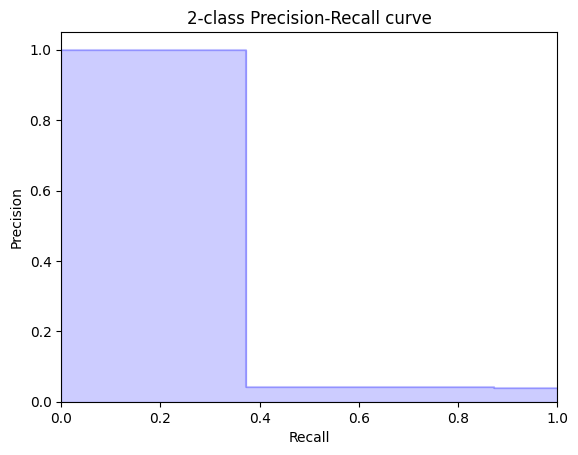

In [104]:
y_test_pred_proba_lr = lr_classifier.predict_proba(x_test)[:,1] # predicted probabilities for being "anomaly"

precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_proba_lr)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')

### ROC curve and AUC
The **ROC curve** is the true positive rate plotted against the false positive rate. We need the predicted probabilities to plot and ROC curves and teh AUC values.

In [105]:
y_test_pred_proba_lr = lr_classifier.predict_proba(x_test)[:,1] # predicted probabilities for being "anomaly"


We use the *pyplot* method in the **matplotlib** library to plot the roc curves.

In [106]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

We use the *roc_curve* method from the **sklearn** library to calculate the false positve and true prositive values for plotting the roc curves.

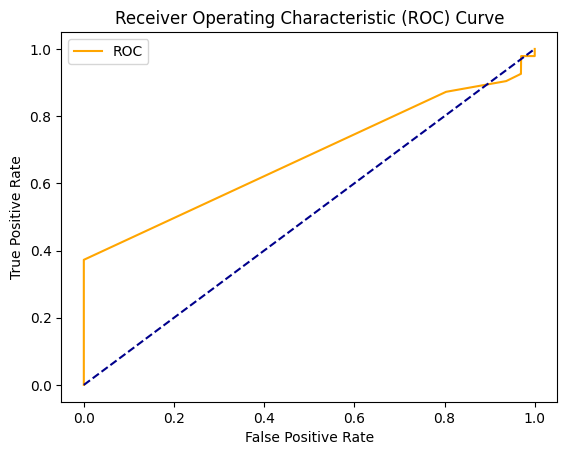

In [107]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_lr)
plot_roc_curve(fpr, tpr)

The **AUC** is the area under the ROC curve, ranging from 0 to 1, the higher the better. A random guess model usually gets an AUC of 0.5. We use the *roc_auc_score* method from the **sklearn** library to calculate the AUC value.

In [108]:
roc_auc = roc_auc_score(y_test, y_test_pred_proba_lr)
print('AUC: %.3f\n' % roc_auc)

AUC: 0.678



## Constructing a decision tree model
Constructing a decision tree model using the *DecisionTreeClassifier* method from the **sklearn** library.

In [109]:
dt_classifier = DecisionTreeClassifier(criterion='gini', max_depth=None,
                          max_features=None, class_weight=None)
dt_classifier.fit(x_train, y_train)

DecisionTreeClassifier()

## Evaluate the performance of the decision tree model

We evaluate the model's performance on the testing set.

### Precision, recall, and f1-score

We use the precision_recall_fscore_support method from the sklearn library to calculate the precision, recall, and f1 measure.

In [110]:
print('Test validation:')
print('====== Evaluation summary ======')
y_test_pred_dt = dt_classifier.predict(x_test)

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred_dt, average='binary')
print('Precision: {:.3f}, recall: {:.3f}, F1-measure: {:.3f}\n'.format(precision, recall, f1))

Test validation:
====== Evaluation summary ======
Precision: 0.976, recall: 0.436, F1-measure: 0.603



### AUC
We need the predicted probabilities to calculate the AUC value.

In [ ]:
y_test_pred_proba_dt = dt_classifier.predict_proba(x_test)[:,1] # predicted probabilities for being "anomaly"

The AUC is the area under the ROC curve, ranging from 0 to 1, the higher the better. A random guess model usually gets an AUC of 0.5. We use the roc_auc_score method from the sklearn library to calculate the AUC value.

In [ ]:
roc_auc = roc_auc_score(y_test, y_test_pred_proba_dt)
print('AUC: %.3f\n' % roc_auc)

AUC: 0.760

